<a href="https://colab.research.google.com/github/Mattlee10/zone2/blob/main/25_05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 데이터 수집

In [ ]:
import xml.etree.ElementTree as ET
import pandas as pd

def parse_health_export(xml_path, record_types=None):
    """
    Apple Health Export XML에서 원하는 Record Type만 추출
    """
    tree = ET.parse(xml_path)
    root = tree.getroot()
    records = []

    for rec in root.findall('Record'):
        rtype = rec.get('type')
        if record_types and rtype not in record_types:
            continue
        val = rec.get('value')
        if val is None:
            continue
        records.append({
            'type': rtype,
            'value': float(val),
            'unit': rec.get('unit'),
            'start': pd.to_datetime(rec.get('startDate')),
            'end': pd.to_datetime(rec.get('endDate'))
        })

    return pd.DataFrame(records)

# XML 경로 설정 (Google Drive에서 마운트한 경로 또는 Colab 업로드 경로)
xml_path = '/content/drive/MyDrive/Export_ds.xml'

# 필요 Record Type 정의
record_types = [
    'HKQuantityTypeIdentifierHeartRate',
    'HKQuantityTypeIdentifierRestingHeartRate',
    'HKQuantityTypeIdentifierHeartRateVariabilitySDNN'
]

# 파싱 실행
df = parse_health_export(xml_path, record_types=record_types)

# 결과 미리보기
print(df.head())

                                type    value       unit  \
0  HKQuantityTypeIdentifierHeartRate  66.0000  count/min   
1  HKQuantityTypeIdentifierHeartRate  77.0000  count/min   
2  HKQuantityTypeIdentifierHeartRate  71.9442  count/min   
3  HKQuantityTypeIdentifierHeartRate  70.0000  count/min   
4  HKQuantityTypeIdentifierHeartRate  75.0000  count/min   

                      start                       end  
0 2021-06-24 22:43:39+09:00 2021-06-24 22:43:39+09:00  
1 2021-06-24 22:44:53+09:00 2021-06-24 22:44:53+09:00  
2 2021-06-24 22:49:47+09:00 2021-06-24 22:49:47+09:00  
3 2021-06-24 22:50:54+09:00 2021-06-24 22:50:54+09:00  
4 2021-06-24 23:00:35+09:00 2021-06-24 23:00:35+09:00  


# 데이터 전처리

In [ ]:
import pandas as pd

# ----------------------------
# 1. 회복/스트레스 분석용 전처리
# ----------------------------
def preprocess_recovery(df, start_date="2025-05-01", end_date="2025-05-20"):
    """HRV + RHR 데이터를 날짜별 평균 및 기준선 포함 형식으로 정리"""

    # 필터링
    df_hrv = df[df['type'] == 'HKQuantityTypeIdentifierHeartRateVariabilitySDNN'].copy()
    df_rhr = df[df['type'] == 'HKQuantityTypeIdentifierRestingHeartRate'].copy()

    # 날짜 파싱
    df_hrv['date'] = df_hrv['start'].dt.date
    df_rhr['date'] = df_rhr['start'].dt.date

    # 기간 필터
    start = pd.to_datetime(start_date).date()
    end = pd.to_datetime(end_date).date()

    df_hrv = df_hrv[(df_hrv['date'] >= start) & (df_hrv['date'] <= end)]
    df_rhr = df_rhr[(df_rhr['date'] >= start) & (df_rhr['date'] <= end)]

    # 일별 평균
    df_hrv_daily = df_hrv.groupby('date')['value'].mean().reset_index().rename(columns={'value': 'hrv'})
    df_rhr_daily = df_rhr.groupby('date')['value'].mean().reset_index().rename(columns={'value': 'rhr'})

    # 병합
    df_daily = pd.merge(df_hrv_daily, df_rhr_daily, on='date', how='inner')

    return df_daily

In [ ]:
# ----------------------------
# 2. Zone 2 감지용 전처리
# ----------------------------
def preprocess_zone2(df, start_date="2025-05-01", end_date="2025-05-20", resample_interval='1min'):
    """HR 데이터를 시간 순 정렬 + 지정 간격으로 리샘플링"""

    df_hr = df[df['type'] == 'HKQuantityTypeIdentifierHeartRate'].copy()
    df_hr['timestamp'] = df_hr['start']

    # 시간 필터
    df_hr = df_hr[(df_hr['timestamp'] >= start_date) & (df_hr['timestamp'] <= end_date)]

    # 인덱스 설정 및 정렬
    df_hr = df_hr.set_index('timestamp').sort_index()

    # 리샘플링: 평균값 기준 (예: 1분 간격)
    df_resampled = df_hr['value'].resample(resample_interval).mean().reset_index()
    df_resampled.columns = ['timestamp', 'hr']

    return df_resampled

상태 판단 로직 추가

In [ ]:
def analyze_recovery(df_daily, baseline_days=5):
    """
    최근 며칠간의 평균을 기준선으로 삼고, 각 날짜별로 회복 상태 판단
    회복 기준: HRV는 기준선보다 높고, RHR은 기준선보다 낮으면 회복 양호
    """
    df = df_daily.copy()
    df = df.sort_values('date')

    # 기준선 계산
    baseline_hrv = df['hrv'].iloc[:baseline_days].mean()
    baseline_rhr = df['rhr'].iloc[:baseline_days].mean()

    # 회복 상태 판단
    df['recovery_status'] = df.apply(
        lambda row: 'Recovered' if (row['hrv'] > baseline_hrv and row['rhr'] < baseline_rhr) else 'Not recovered',
        axis=1
    )

    return df, baseline_hrv, baseline_rhr

Zone 2 심박수 구간 설정 및 운동구간 감지

In [ ]:
def detect_zone2(df_hr, age=30):
    """
    나이 기반으로 Zone 2 범위 설정 후 구간 감지 (기본 공식을 활용)
    Zone 2: 60~70% of HRmax
    """
    hr_max = 220 - 31
    zone2_min = hr_max * 0.6
    zone2_max = hr_max * 0.7

    df = df_hr.copy()
    df['in_zone2'] = df['hr'].apply(lambda x: zone2_min <= x <= zone2_max)

    return df, zone2_min, zone2_max

In [ ]:
def extract_continuous_zone2(df_zone2, min_duration='10min'):
    """
    Zone 2 내 심박수 유지가 연속적으로 일정 시간 이상인 구간 탐지
    """
    df = df_zone2.copy()
    df['zone2_block'] = (df['in_zone2'] != df['in_zone2'].shift()).cumsum()

    # 그룹별로 Zone 2 구간만 필터링
    zone2_groups = df[df['in_zone2']].groupby('zone2_block')

    valid_blocks = []
    for _, group in zone2_groups:
        duration = group['timestamp'].iloc[-1] - group['timestamp'].iloc[0]
        if duration >= pd.to_timedelta(min_duration):
            valid_blocks.append(group)

    # 결과 병합
    result_df = pd.concat(valid_blocks) if valid_blocks else pd.DataFrame(columns=df.columns)
    return result_df

시각화

In [ ]:
import matplotlib.pyplot as plt

def plot_recovery_trend(df, baseline_hrv, baseline_rhr):
    plt.figure(figsize=(12, 6))
    plt.plot(df['date'], df['hrv'], label='HRV (ms)', marker='o')
    plt.plot(df['date'], df['rhr'], label='RHR (bpm)', marker='o')
    plt.axhline(baseline_hrv, color='blue', linestyle='--', label='Baseline HRV')
    plt.axhline(baseline_rhr, color='orange', linestyle='--', label='Baseline RHR')

    # 회복 상태 마커
    for i, row in df.iterrows():
        color = 'green' if row['recovery_status'] == 'Recovered' else 'red'
        plt.scatter(row['date'], row['hrv'], color=color, s=100, alpha=0.3)

    plt.title('Recovery Trend (HRV & RHR)')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [ ]:
def plot_zone2_heart_rate(df, zone2_min, zone2_max):
    plt.figure(figsize=(12, 5))
    plt.plot(df['timestamp'], df['hr'], label='Heart Rate', color='black')

    # Zone 2 범위
    plt.axhline(zone2_min, color='blue', linestyle='--', label='Zone 2 Min')
    plt.axhline(zone2_max, color='blue', linestyle='--', label='Zone 2 Max')

    # Zone 2 구간 강조
    plt.fill_between(df['timestamp'], df['hr'], zone2_min, where=df['in_zone2'], color='green', alpha=0.3, label='Zone 2')

    plt.title('Heart Rate with Zone 2 Detection')
    plt.xlabel('Time')
    plt.ylabel('HR (bpm)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [ ]:
def analyze_recovery(df_daily, baseline_days=5):
    """
    HRV/RHR 일별 평균 기반 회복 상태 판단
    - HRV ↑ + RHR ↓ 이면 Recovered로 간주
    """
    df = df_daily.copy()
    df = df.sort_values('date')

    # 기준선 설정
    baseline_hrv = df['hrv'].iloc[:baseline_days].mean()
    baseline_rhr = df['rhr'].iloc[:baseline_days].mean()

    # 회복 상태 판단
    df['recovery_status'] = df.apply(
        lambda row: 'Recovered' if (row['hrv'] > baseline_hrv and row['rhr'] < baseline_rhr) else 'Not recovered',
        axis=1
    )

    return df, baseline_hrv, baseline_rhr

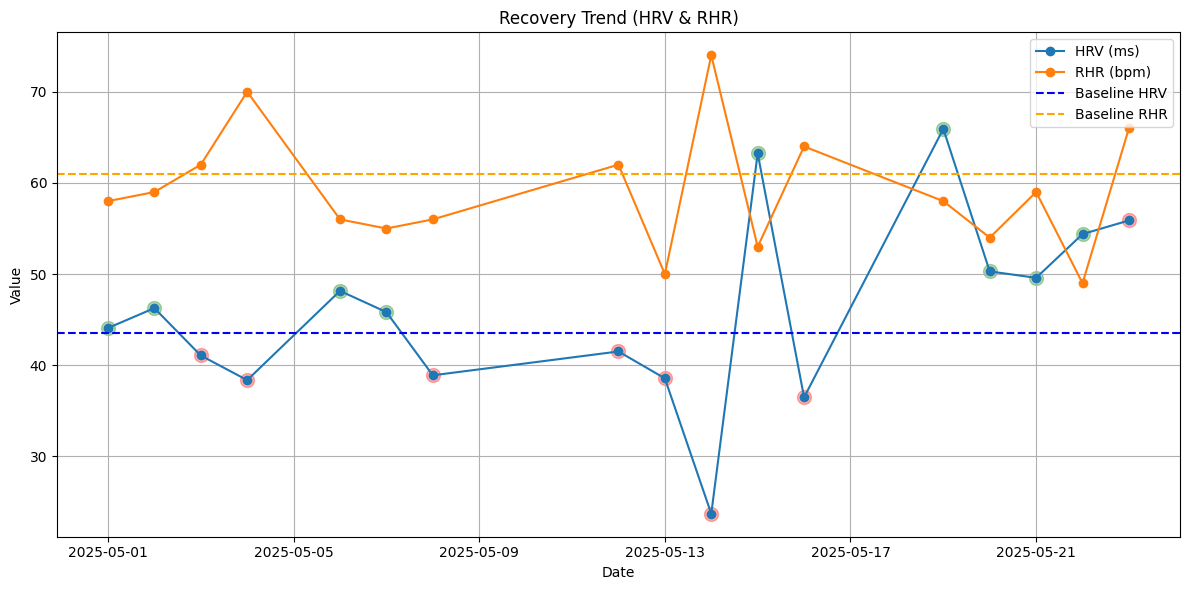

In [ ]:
# 전처리 함수 먼저 실행했어야 함
df_daily = preprocess_recovery(df, start_date="2025-05-01", end_date="2025-05-25")

# 회복 분석 실행
df_result, baseline_hrv, baseline_rhr = analyze_recovery(df_daily)

# 시각화
plot_recovery_trend(df_result, baseline_hrv, baseline_rhr)

In [ ]:
import matplotlib.pyplot as plt

def plot_zone2_heart_rate(df, age=31):
    """
    시각화: 전체 심박수 그래프 + Zone 2 범위 표시 + Zone 2 구간 강조
    """
    # Zone 2 계산
    hr_max = 220 - age
    zone2_min = hr_max * 0.6
    zone2_max = hr_max * 0.7

    # 시각화
    plt.figure(figsize=(14, 6))
    plt.plot(df['timestamp'], df['hr'], label='Heart Rate', color='black', linewidth=1)

    # Zone 2 범위 선
    plt.axhline(zone2_min, color='blue', linestyle='--', label=f'Zone 2 Min ({int(zone2_min)} bpm)')
    plt.axhline(zone2_max, color='blue', linestyle='--', label=f'Zone 2 Max ({int(zone2_max)} bpm)')

    # Zone 2 범위 구간 강조
    plt.fill_between(df['timestamp'], df['hr'], zone2_min, where=df['in_zone2'],
                     color='green', alpha=0.3, label='Zone 2')

    plt.title(f'Heart Rate with Zone 2 Detection (Age: {age})')
    plt.xlabel('Time')
    plt.ylabel('Heart Rate (bpm)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [ ]:
def detect_zone2_detailed(df_hr, age=31, resting_hr=60, intensity_range=(0.6, 0.7)):
    """
    Karvonen 기반 Zone 2 감지 + Zone 2 내 세부 레벨 구간 분류
    """

    hr_max = 220 - age
    reserve = hr_max - resting_hr

    # 전체 Zone 2 범위 (Karvonen 공식)
    zone2_min = resting_hr + reserve * intensity_range[0]
    zone2_max = resting_hr + reserve * intensity_range[1]
    zone2_range = zone2_max - zone2_min

    df = df_hr.copy()

    def classify_zone2_level(hr):
        if hr < zone2_min or hr > zone2_max:
            return 'Out of Zone 2'
        rel_pos = (hr - zone2_min) / zone2_range
        if rel_pos < 0.2:
            return 'Zone 2 - Level 1 (0~20%)'
        elif rel_pos < 0.4:
            return 'Zone 2 - Level 2 (20~40%)'
        elif rel_pos < 0.6:
            return 'Zone 2 - Level 3 (40~60%)'
        else:
            return 'Zone 2 - Level 4 (60~100%)'

    df['zone2_level'] = df['hr'].apply(classify_zone2_level)

    return df, zone2_min, zone2_max

In [ ]:
df_zone2_detailed, zone2_min, zone2_max = detect_zone2_detailed(df_hr, age=31, resting_hr=60)

# 예시 출력
print(df_zone2_detailed[['timestamp', 'hr', 'zone2_level']].head())

                  timestamp    hr                 zone2_level
0 2025-05-19 12:23:00+09:00  78.0               Out of Zone 2
1 2025-05-19 12:24:00+09:00   NaN  Zone 2 - Level 4 (60~100%)
2 2025-05-19 12:25:00+09:00  79.0               Out of Zone 2
3 2025-05-19 12:26:00+09:00   NaN  Zone 2 - Level 4 (60~100%)
4 2025-05-19 12:27:00+09:00   NaN  Zone 2 - Level 4 (60~100%)


In [ ]:
import matplotlib.pyplot as plt

def plot_zone2_levels_bar(df_zone2_detailed):
    """
    Zone 2 세부 강도 비율을 막대그래프로 시각화
    """
    df = df_zone2_detailed[df_zone2_detailed['zone2_level'].str.startswith('Zone 2')]
    level_counts = df['zone2_level'].value_counts(normalize=True).sort_index() * 100

    plt.figure(figsize=(8, 5))
    level_counts.plot(kind='bar')
    plt.title('Zone 2 Sub-Level Distribution')
    plt.ylabel('Percentage (%)')
    plt.xlabel('Zone 2 Level')
    plt.ylim(0, 100)
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

In [ ]:
def plot_zone2_levels_pie(df_zone2_detailed):
    """
    Zone 2 세부 강도 비율을 파이차트로 시각화
    """
    df = df_zone2_detailed[df_zone2_detailed['zone2_level'].str.startswith('Zone 2')]
    level_counts = df['zone2_level'].value_counts().sort_index()

    plt.figure(figsize=(6, 6))
    plt.pie(level_counts, labels=level_counts.index, autopct='%1.1f%%', startangle=140)
    plt.title('Zone 2 Sub-Level Distribution (Pie Chart)')
    plt.tight_layout()
    plt.show()

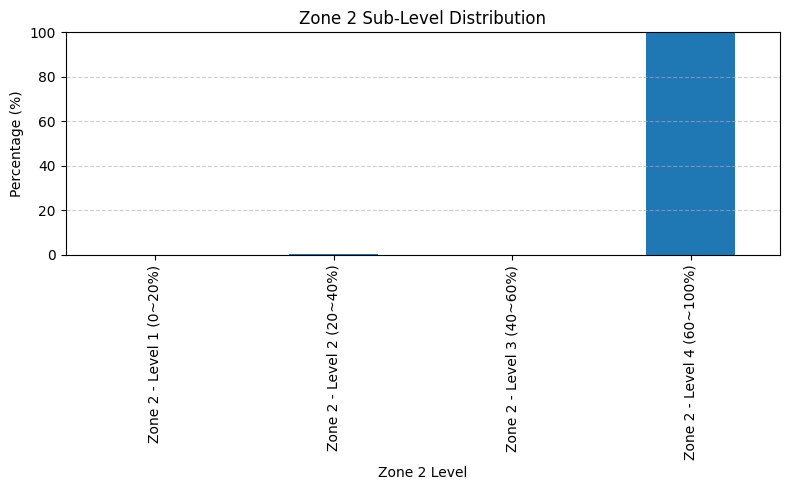

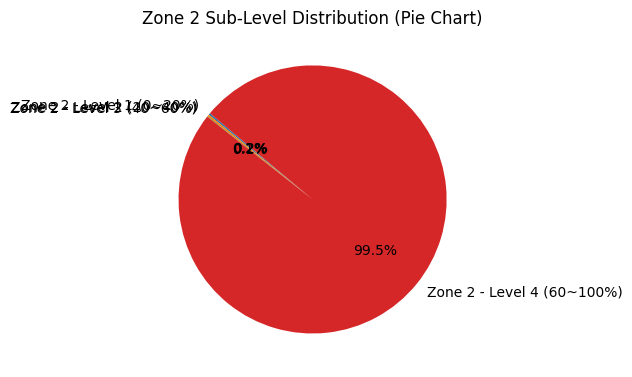

In [ ]:
# 막대그래프 시각화
plot_zone2_levels_bar(df_zone2_detailed)

# 파이차트 시각화
plot_zone2_levels_pie(df_zone2_detailed)

In [ ]:
import matplotlib.pyplot as plt

def plot_zone2_levels_bar(df_zone2_detailed):
    """
    Zone 2 세부 강도 비율을 막대그래프로 시각화 (개선된 버전)
    """
    df = df_zone2_detailed[df_zone2_detailed['zone2_level'].str.startswith('Zone 2')]
    level_counts = df['zone2_level'].value_counts(normalize=True).sort_index() * 100

    plt.figure(figsize=(10, 6))
    bars = plt.bar(level_counts.index, level_counts.values, color='skyblue', edgecolor='black')

    # 비율 라벨 추가
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height + 1, f'{height:.1f}%', ha='center', fontsize=10)

    plt.title('Zone 2 Sub-Level Distribution (Bar Chart)', fontsize=14)
    plt.ylabel('Percentage (%)')
    plt.ylim(0, max(level_counts.values)*1.2)
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.xticks(rotation=15)
    plt.show()

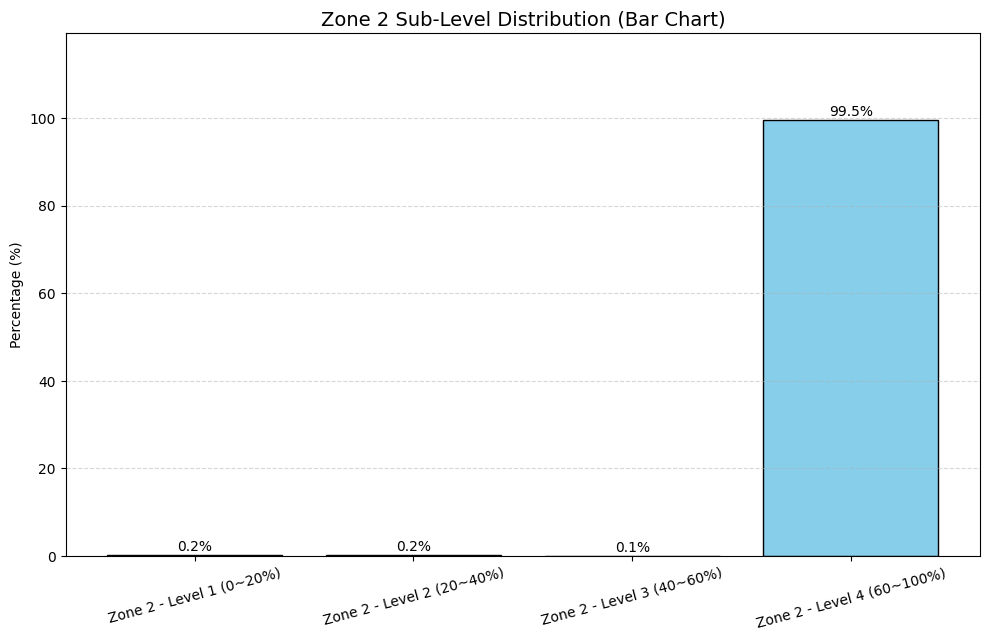

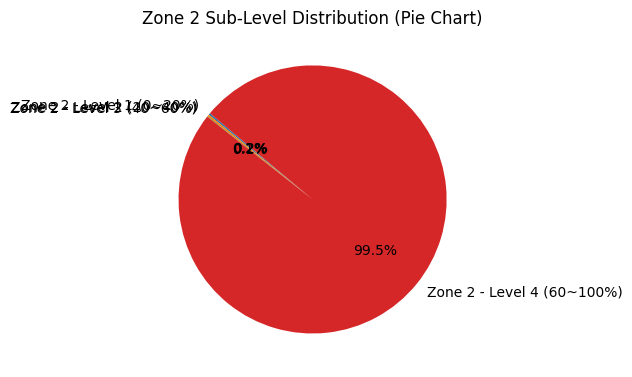

In [ ]:
plot_zone2_levels_bar(df_zone2_detailed)
plot_zone2_levels_pie(df_zone2_detailed)

In [ ]:
def summarize_zone2_levels_by_date(df_zone2_detailed):
    """
    날짜별 Zone 2 레벨 비율 요약 테이블 생성 (0~100%)
    """
    df = df_zone2_detailed[df_zone2_detailed['zone2_level'].str.startswith('Zone 2')].copy()
    df['date'] = df['timestamp'].dt.date

    level_counts = df.groupby(['date', 'zone2_level']).size().unstack(fill_value=0)
    level_ratio = level_counts.div(level_counts.sum(axis=1), axis=0) * 100  # 퍼센트 비율

    return level_ratio.round(2)

In [ ]:
import matplotlib.pyplot as plt

def plot_zone2_levels_by_date(df_zone2_detailed):
    """
    날짜별 Zone 2 레벨 비율을 스택 막대그래프로 시각화
    """
    df_summary = summarize_zone2_levels_by_date(df_zone2_detailed)

    plt.figure(figsize=(12, 6))
    df_summary.plot(kind='bar', stacked=True, colormap='Blues', edgecolor='black', width=0.7)

    plt.title('Daily Zone 2 Sub-Level Distribution', fontsize=14)
    plt.xlabel('Date')
    plt.ylabel('Percentage (%)')
    plt.ylim(0, 100)
    plt.legend(title='Zone 2 Level', bbox_to_anchor=(1.02, 1), loc='upper left')
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

<Figure size 1200x600 with 0 Axes>

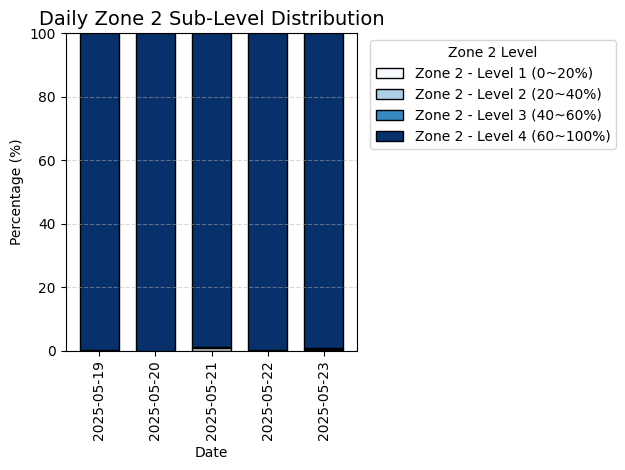

In [ ]:
plot_zone2_levels_by_date(df_zone2_detailed)

In [ ]:
def summarize_zone2_ratio_by_date(df_zone2):
    """
    날짜별로 전체 심박수 중 Zone 2 비율(%)을 계산
    - df_zone2: 'timestamp', 'hr', 'in_zone2' 컬럼 포함한 데이터프레임
    """
    df = df_zone2.copy()
    df['date'] = df['timestamp'].dt.date

    total_counts = df.groupby('date').size().rename('total')
    zone2_counts = df[df['in_zone2']].groupby('date').size().rename('zone2')

    df_summary = pd.concat([total_counts, zone2_counts], axis=1).fillna(0)
    df_summary['zone2_percent'] = (df_summary['zone2'] / df_summary['total']) * 100
    return df_summary.reset_index()

In [ ]:
import matplotlib.pyplot as plt

def plot_zone2_ratio_by_date(df_zone2):
    """
    날짜별 Zone 2 비율(%)을 막대그래프로 시각화
    """
    df_summary = summarize_zone2_ratio_by_date(df_zone2)

    plt.figure(figsize=(10, 5))
    bars = plt.bar(df_summary['date'], df_summary['zone2_percent'], color='mediumseagreen', edgecolor='black')

    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height + 1, f'{height:.1f}%', ha='center', fontsize=9)

    plt.title('Zone 2 Time Ratio by Date')
    plt.xlabel('Date')
    plt.ylabel('Zone 2 (%)')
    plt.ylim(0, 100)
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

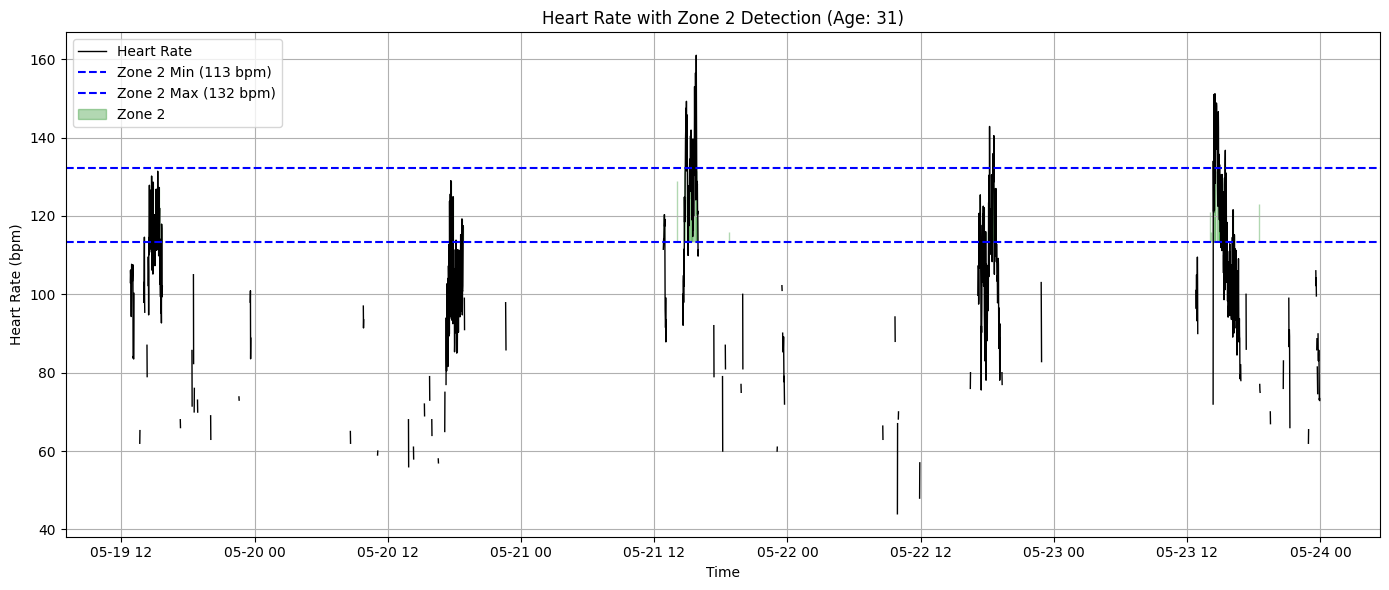

In [ ]:
# df_zone2 = detect_zone2() 함수의 출력 중 첫 번째 값
plot_zone2_heart_rate(df_zone2, age=31)